In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\crowl\AppData\Local\Temp\ipykernel_23608\430117948.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


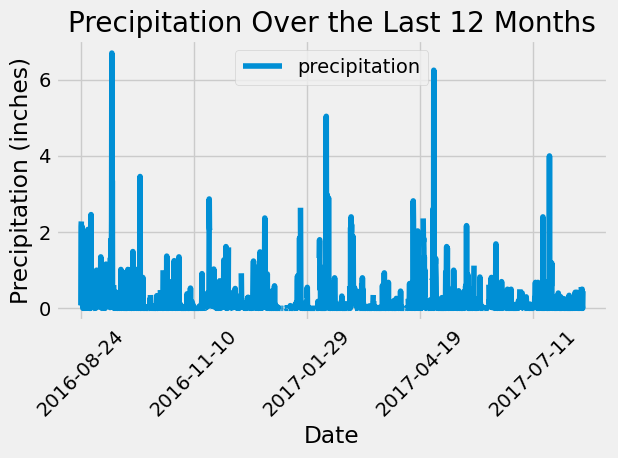

In [10]:
# Design a query to retrieve the last 12 months of precipitation data
# Starting from the most recent data point in the database.

most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Convert most_recent_date to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the last date in the dataset
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the DataFrame by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', title='Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()

print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f'The total number of stations in the dataset is: {total_stations}')

The total number of stations in the dataset is: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station).label('activity_count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_activity_df = pd.DataFrame(station_activity, columns=['Station', 'Activity Count'])

print(station_activity_df)

       Station  Activity Count
0  USC00519281            2772
1  USC00519397            2724
2  USC00513117            2709
3  USC00519523            2669
4  USC00516128            2612
5  USC00514830            2202
6  USC00511918            1979
7  USC00517948            1372
8  USC00518838             511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = station_activity[0][0]

temperature_stats = session.query(func.min(Measurement.tobs).label('min_temp'),
                                 func.max(Measurement.tobs).label('max_temp'),
                                 func.avg(Measurement.tobs).label('avg_temp')).\
    filter(Measurement.station == most_active_station_id).all()

min_temp, max_temp, avg_temp = temperature_stats[0]

print(f"Temperature statistics for the most active station (Station ID: {most_active_station_id}):")
print(f"Lowest Temperature: {min_temp} °F")
print(f"Highest Temperature: {max_temp} °F")
print(f"Average Temperature: {round(avg_temp, 2)} °F")

Temperature statistics for the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


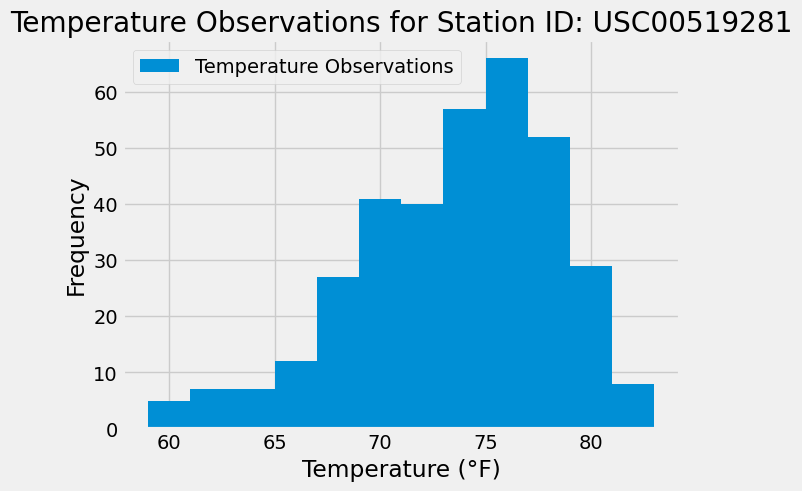

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

plt.hist(temperature_df['Temperature'], bins=12, label='Temperature Observations')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station ID: {most_active_station_id}')
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()